In [ ]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# New Loss

In this notebook, I will code up a DFE with new loss function discussed on July 18th, 2022.

The loss function is as follows:

$$\sum\limits_{i,j \in V}|d_{diff}(x_i,x_j)-||\phi(x_i)-\phi(x_j)||_2|$$ $$+ \beta \sum\limits_{i \in V} \sum\limits_{k \in N_f(i)} ||(\phi(x_k)-\phi(x_i))-f(\phi(x_i))||_2$$ $$+ \gamma \cdot smoothness$$ $$+ \delta \cdot CLL (contrastive learning loss)$$

# Affinity Functions

In [ ]:
def affinity_from_flow(flow, directions_array, flow_strength = 1, sigma=1):
  """Compute probabilities of transition in the given directions based on the flow. 

  Parameters
  ----------
  flow : torch tensor of shape n_points x n_dims
      _description_
  directions_array : torch tensor of shape n_directions x n_points x n_dims. Assumed to be normalized.
      _description_
  sigma : int, optional
      kernel bandwidth, by default 1
  returns (n_points)
  """
  assert len(flow.shape) == 2 # flow should only have one dimension
  assert len(directions_array.shape) > 1 and len(directions_array.shape) < 4
  n_directions = directions_array.shape[0]
  # Normalize directions
  length_of_directions = torch.linalg.norm(directions_array,dim=-1)
  normed_directions = F.normalize(directions_array,dim=-1)
  # and normalize flow # TODO: Perhaps reconsider
  # Calculate flow lengths, used to scale directions to flow
  # flow_lengths = torch.linalg.norm(flow,dim=-1)
  if len(directions_array) == 1: # convert to 2d array if necessary
    directions_array = directions_array[:,None] 
  # scale directions to have same norm as flow
  # scaled_directions = normed_directions * flow_lengths[:,None].repeat(directions_array.shape[0],1,directions_array.shape[2])
  # compute dot products as matrix multiplication
  dot_products = (normed_directions * flow).sum(-1)
  # take distance between flow projected onto direction and the direction
  distance_from_flow = (torch.linalg.norm(flow,dim=1)).repeat(n_directions,1) - dot_products
  # take absolute value
  distance_from_flow = torch.abs(distance_from_flow)
  # print('shape of dff',distance_from_flow.shape)
  # add to this the length of each direction
  distance_from_flow = flow_strength*distance_from_flow + length_of_directions
  # put the points on rows, directions in columns
  distance_from_flow = distance_from_flow.T
  # take kernel of distances
  kernel =  torch.exp(-distance_from_flow/sigma)
  return kernel

In [ ]:
def affinity_matrix_from_pointset_to_pointset(pointset1, pointset2, flow,n_neighbors=None,sigma=0.5, flow_strength=1):
  """Compute affinity matrix between the points of pointset1 and pointset2, using the provided flow.

  Parameters
  ----------
  pointset1 : torch tensor, n1 x d
      The first pointset, to calculate affinities *from*
  pointset2 : torch tensor, n2 x d
      The second pointset, to calculate affinities *to* (from pointset1)
  flow : a function that, when called at a point, gives the flow at that point
  n_neighbors : number of neighbors to include in affinity computations. All neighbors beyond it are given affinity zero
  (currently not implemented)

  Returns:
  Affinity matrix: torch tensor of shape n1 x n2
  """
  # Calculate the directions from point i in pointset 1 to point j in pointset 2
  n1 = pointset1.shape[0]
  n2 = pointset2.shape[0]
  P2 = pointset2[:,:,None].repeat(1,1,n1)
  P1 = pointset1.T.repeat(n2,1,1)
  P3 = (P2 - P1)
  P3 = P3.transpose(1,2)
  # dimension 1 represents directions to point i
  # dimension 2 represents direction from point j
  # dimension 3 represents direction in each dimension (R^n)
  # compute affinities from flow and directions
  affinities = affinity_from_flow(flow,P3,sigma=sigma,flow_strength=flow_strength)
  return affinities

# Flexible FlowArtist and Encoder (ReLU MLPs) Object Creator Function

In [ ]:
from collections import OrderedDict

def FlowArtist(dim = 2, shape = [2,4,8,4,2], device = torch.device('cpu')):
    # Function to create tailored flow artist
    
    FA = nn.Sequential()
    
    d_len = len(shape)*2
    d = OrderedDict()
    d[str(0)] = nn.Linear(shape[0], shape[1])
    for i in range(1,d_len-3):
        if i%2 == 1:
            d[str(i)] = nn.LeakyReLU()
        else:
            d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
    
    # create MLP
    FA = nn.Sequential(d) # d is an OrderedDictionary
        
    return FA

In [ ]:
class FeedForwardReLU(nn.Module):
    def __init__(self, shape):
        super(FeedForwardReLU, self).__init__()
        d_len = len(shape) * 2
        d = OrderedDict()
        d[str(0)] = nn.Linear(shape[0], shape[1])
        for i in range(1, d_len - 3):
            if i % 2 == 1:
                d[str(i)] = nn.LeakyReLU()
            else:
                d[str(i)] = nn.Linear(shape[int(i / 2)], shape[int(i / 2) + 1])
        # create MLP
        self.FA = nn.Sequential(d)

    def forward(self, X):
        return self.FA(X)

# Loss Functions

In [ ]:
def diffusion_map_loss(P_graph, embedded_points):
  num_nodes = P_graph.shape[0]
  D_graph = torch.cdist(P_graph, P_graph)
  D_embedding = torch.cdist(embedded_points, embedded_points)
  loss = torch.norm(D_graph - D_embedding)**2 / (num_nodes**2)
  return loss

def near_neighbors_tensor(points, affinity_matrix, k):
    # returns n x k (neighbors) x dimensions Tensor
    A = affinity_matrix
    n = A.shape[0]
    d = points.size()[1]
    _, indices = torch.topk(A, k)
    
    ret = torch.empty(size=(n,k,d)).to(device)
    
    for i in range(indices.size()[0]):
        for j in range(indices.size()[1]):
            index = indices[i][j]
            ret[i][j] = points[index]
    
    return ret

def flow_neighbor_loss(points, near_neighbors, encoder, flow_artist):
    
    k = near_neighbors.shape[1]
    embedded_points = encoder(points)
    embedded_points = embedded_points[:,None,:].repeat(1,k,1)
    
    big_mat = encoder(near_neighbors) - embedded_points - flow_artist(embedded_points)
    norms = torch.linalg.norm(big_mat, dim = 2)
    
    return torch.sum(norms)

### Test Functions

In [ ]:
points = [[0,0],
         [1,0],
         [0,1],
         [-1,0],
         [0,-1]]

flow = [[1,0],
         [1,0],
         [1,0],
         [1,0],
         [1,0]]

points = torch.tensor(points).float()
flow = torch.tensor(flow).float()

#plt.scatter(points[:,0], points[:,1])
#plt.quiver(points[:,0], points[:,1], flow[:,0], flow[:,1])

In [ ]:
A = affinity_matrix_from_pointset_to_pointset(points, points, flow)
A
#plt.imshow(A)

tensor([[0.1353, 0.1353, 0.0183, 0.0025, 0.0183],
        [0.0025, 0.1353, 0.0019, 0.0003, 0.0019],
        [0.0183, 0.0329, 0.1353, 0.0019, 0.0025],
        [0.1353, 0.0183, 0.0329, 0.1353, 0.0329],
        [0.0183, 0.0329, 0.0025, 0.0019, 0.1353]])

In [ ]:
near_neighbors_tensor(points, A, 2).size()[2]

2

# Embedder Class

In [ ]:
class FlowEmbedder(torch.nn.Module):
    def __init__(
        self,
        X,
        flow,
        sigma_graph=0.5,
        flow_strength_graph=5,
        embedding_dimension=2,
        learning_rate=1e-3,
        FAShape=(2, 4, 8, 4, 2),
        EncShape=(3, 4, 8, 4, 2),
        decoder=None,
        labels=None,
        loss_weights=None,
        knn = 10,
        device=torch.device("cpu"),
    ):
        # initialize parameters
        super(FlowEmbedder, self).__init__()

        # generate default parameters
        embedder = (
            FeedForwardReLU(shape=EncShape)
        )
        loss_weights = (
            {
                "points": 1,
                "flow": 1,
                "smoothness": 0,
                "CLL": 0,
            }
            if loss_weights is None
            else loss_weights
        )
        self.X = X
        self.flow = flow
        self.sigma_graph = sigma_graph
        self.nnodes = X.shape[0]
        self.data_dimension = X.shape[1]

        self.loss_weights = loss_weights
        self.labels = labels
        self.embedding_dimension = embedding_dimension
        # set device (used for shuffling points around during visualization)
        self.device = device

        # Affinity Matrix in Ambient Space
        self.P_graph = affinity_matrix_from_pointset_to_pointset(
            X, X, flow, sigma=sigma_graph, flow_strength=flow_strength_graph
        )
        self.P_graph = F.normalize(self.P_graph, p=1, dim=1)
        
        # Ambient space points neighbors
        self.knn = knn
        self.near_neighbors = near_neighbors_tensor(self.X, self.P_graph, self.knn)
        
        # Flow field
        self.FlowArtist = FlowArtist(dim = 2, 
                                     shape = FAShape, 
                                     device = torch.device('cpu')
        ).to(self.device)

        # Autoencoder to embed the points into a low dimension
        
        self.embedder = embedder
        if decoder is not None:
            self.decoder = decoder.to(self.device)
        else:
            self.decoder = None

        # training ops
        self.optim = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # split input data into batches

    def loss(self, epoch):
        # embed points
        self.embedded_points = self.embedder(self.X)
        # compute diffusion loss on embedded points
        
        #"""
        # compute point embedding loss according to diffusion maps
        diffmap_loss = diffusion_map_loss(self.P_graph, self.embedded_points)
        self.losses["points"].append(diffmap_loss)
        #"""
        
        #"""
        # compute flow field loss
        flow_loss = flow_neighbor_loss(self.X, self.near_neighbors, self.embedder, self.FlowArtist)#*10e-6
        self.losses["flow"].append(flow_loss)
        #"""

        if epoch < 5000:
            loss = diffmap_loss
        else:
             loss = diffmap_loss + flow_loss*10e-5
        
        return loss

    def visualize_points(self, labels=None):
        embedded_points = self.embedder(X)
        
        xmin = float(torch.min(embedded_points[:,0]))
        xmax = float(torch.max(embedded_points[:,0]))
        ymin = float(torch.min(embedded_points[:,1]))
        ymax = float(torch.max(embedded_points[:,1]))
        
        x_grid = torch.arange(xmin, xmax, (xmax-xmin)/20)
        y_grid = torch.arange(ymin, ymax, (ymax-ymin)/20)
        
        grid = []
        
        for i in range(20):
            for j in range(20):
                grid.append([x_grid[i], y_grid[j]])
        
        grid = torch.tensor(grid).float().to(device)
        flow = self.FlowArtist(grid)
        
        plt.scatter(embedded_points[:,0].cpu().detach(), embedded_points[:,1].cpu().detach(), c=labels)
        plt.quiver(grid[:,0].cpu().detach(),grid[:,1].cpu().detach(),flow[:,0].cpu().detach(),flow[:,1].cpu().detach())
        plt.show()

    def visualize_loss(self, loss_type="total"):
        # diffusion_loss,reconstruction_loss, smoothness_loss
        x = []
        k = ""
        losses = {}
        for key in self.losses.keys():
            losses[key] = []
            k = key
        losses["total"] = []
        for i in range(len(self.losses["points"])):
            x.append(i)
            for key in self.losses.keys():
                try:
                    losses[key].append(self.losses[key][i].detach().cpu().numpy())
                except:
                    losses[key].append(0)
        if loss_type == "all":
            for key in self.losses.keys():
                plt.plot(x, losses[key])
            plt.legend(self.losses.keys(), loc="upper right")
            plt.title("loss")
        else:
            plt.plot(x, losses[loss_type])
            plt.title(loss_type)
        
    def fit(self, n_steps=1000):
        # train Flow Embedder on the provided graph
        self.train()
        # reset losses
        self.losses = {}
        for k in self.loss_weights.keys():
            self.losses[k] = []
        # self.weight_of_flow = 0
        for step in trange(n_steps):
            # vary weight of each part of loss function
            """ 
            if step == 100:
                self.weight_of_flow = 1
            if step == 200:
                self.weight_of_flow = 0.5
            """
            self.optim.zero_grad()
            # compute loss
            loss = self.loss(step)
            if loss.isnan():
                print("Final loss was nan")
                raise NotImplementedError
            # compute gradient and step backwards
            loss.backward()
            self.optim.step()
            # print progress report after every 500 epochs
            #"""
            if step % 100 == 0:
                print(f"EPOCH {step}.")
                self.visualize_points()
            #"""
            # TODO: Criteria to automatically end training
        # print("Exiting training with loss ",loss)
        # return self.embedded_points, self.FlowArtist, self.losses

# Testing library functions

In [ ]:
A = [[3,2,1],[5,4,6],[9,7,8]]
A = torch.tensor(A).float()

A

tensor([[3., 2., 1.],
        [5., 4., 6.],
        [9., 7., 8.]])

In [ ]:
_, indices = torch.topk(A, 2)
indices

tensor([[0, 1],
        [2, 0],
        [0, 2]])

In [ ]:
ret = np.empty(shape=(10,4))

In [ ]:
p = [[1,0], [0,1]]
p = torch.tensor(p).float()

p.repeat(2,1,1)

tensor([[[1., 0.],
         [0., 1.]],

        [[1., 0.],
         [0., 1.]]])

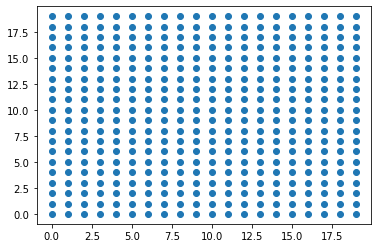

In [ ]:
xmin = 0
xmax = 20
ymin = 0
ymax = 20

x_grid = torch.arange(xmin, xmax, (xmax-xmin)/20)
y_grid = torch.arange(ymin, ymax, (ymax-ymin)/20)
        
grid = []
        
for i in range(20):
    for j in range(20):
        grid.append([x_grid[i], y_grid[j]])
    
grid = np.asarray(grid)
    
plt.scatter(grid[:,0], grid[:,1])

# Testing the Embedder

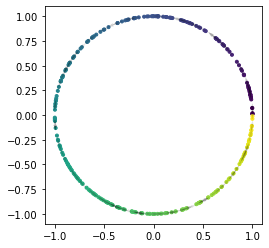

In [ ]:
from directed_graphs.datasets import directed_circle
from directed_graphs.datasets import plot_directed_2d, plot_directed_3d

X, flow, labels = directed_circle(num_nodes=300, radius=1)
plot_directed_2d(X, flow, labels)
X = torch.tensor(X).float().to(device)
flow = torch.tensor(flow).float().to(device)

In [ ]:
X.shape

torch.Size([300, 3])

In [ ]:
FE = FlowEmbedder(X,
                  flow,
                  FAShape=(2, 4, 8, 4, 2),
                  EncShape=(3, 4, 8, 4, 2),
                  knn = 10,
                  device = device).to(device)

  0%|          | 0/10000 [00:00<?, ?it/s]

EPOCH 0.


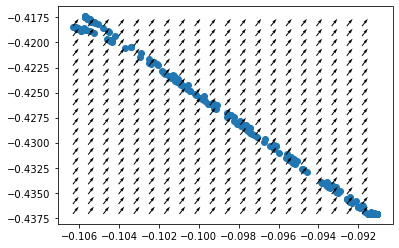

  1%|          | 89/10000 [00:01<01:29, 111.19it/s]

EPOCH 100.


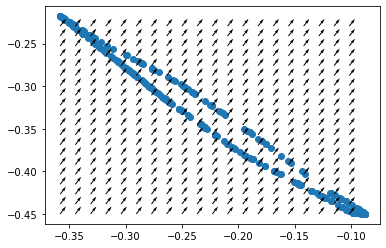

  2%|▏         | 190/10000 [00:02<01:35, 102.76it/s]

EPOCH 200.


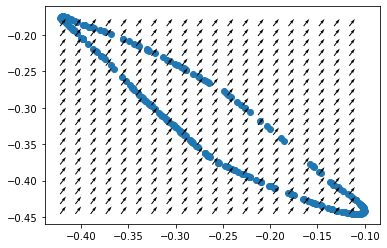

  3%|▎         | 293/10000 [00:03<01:26, 112.73it/s]

EPOCH 300.


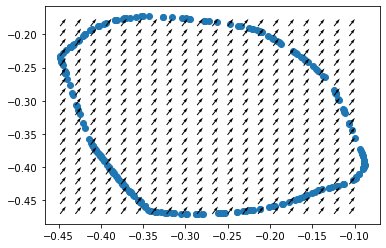

  4%|▍         | 396/10000 [00:04<01:24, 113.12it/s]

EPOCH 400.


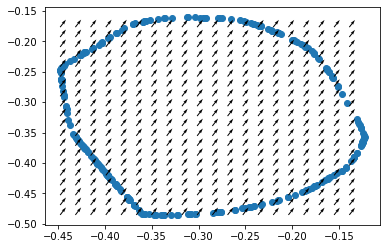

  5%|▍         | 498/10000 [00:05<01:24, 112.39it/s]

EPOCH 500.


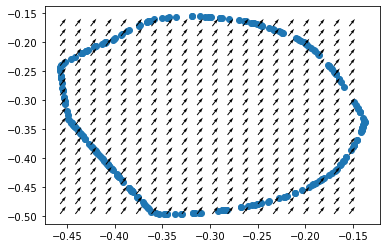

  6%|▌         | 588/10000 [00:06<01:26, 108.87it/s]

EPOCH 600.


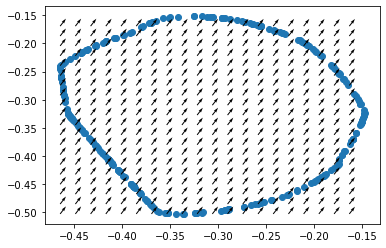

  7%|▋         | 692/10000 [00:08<01:23, 111.99it/s]

EPOCH 700.


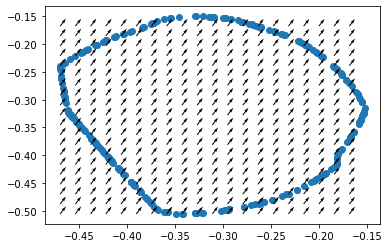

  8%|▊         | 795/10000 [00:09<01:21, 112.33it/s]

EPOCH 800.


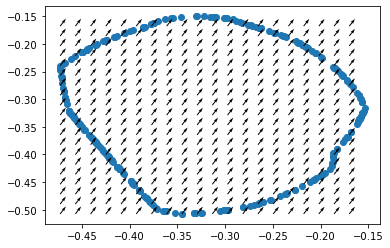

  9%|▉         | 898/10000 [00:10<01:20, 113.27it/s]

EPOCH 900.


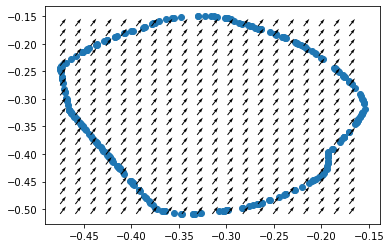

 10%|█         | 1000/10000 [00:11<01:20, 111.56it/s]

EPOCH 1000.


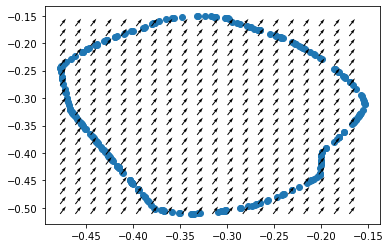

 11%|█         | 1096/10000 [00:12<01:22, 108.07it/s]

EPOCH 1100.


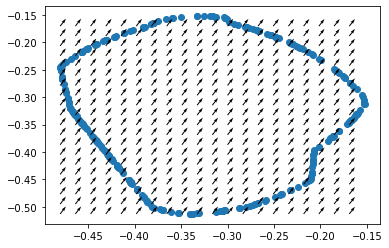

 12%|█▏        | 1191/10000 [00:13<01:31, 95.93it/s] 

EPOCH 1200.


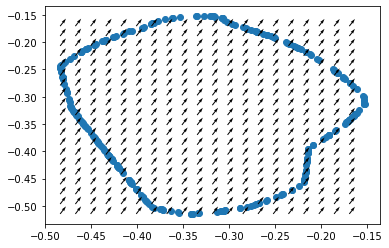

 13%|█▎        | 1298/10000 [00:15<01:19, 109.82it/s]

EPOCH 1300.


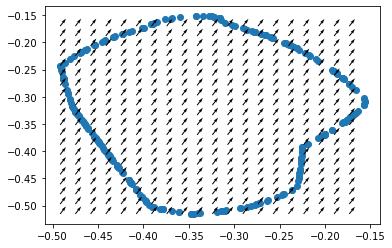

 14%|█▍        | 1394/10000 [00:16<01:19, 107.68it/s]

EPOCH 1400.


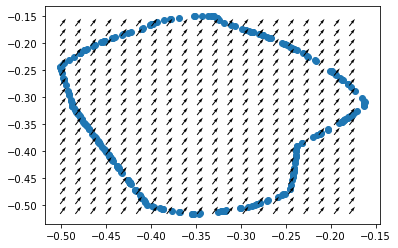

 15%|█▍        | 1490/10000 [00:17<01:19, 107.03it/s]

EPOCH 1500.


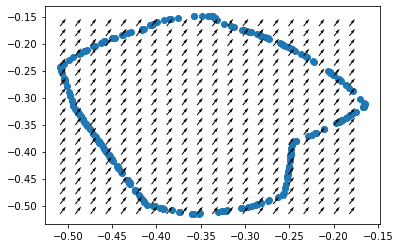

 16%|█▌        | 1598/10000 [00:18<01:16, 109.30it/s]

EPOCH 1600.


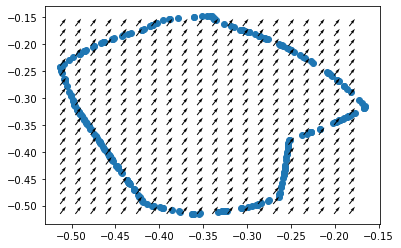

 17%|█▋        | 1694/10000 [00:19<01:17, 107.47it/s]

EPOCH 1700.


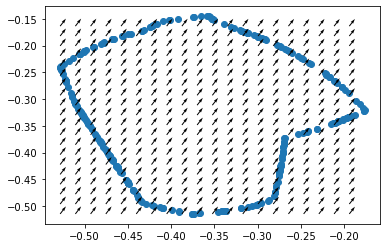

 18%|█▊        | 1790/10000 [00:21<01:16, 107.10it/s]

EPOCH 1800.


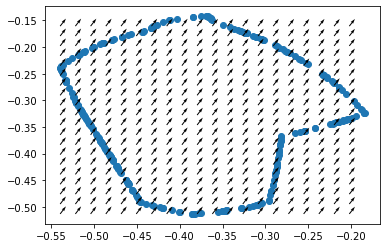

 19%|█▉        | 1897/10000 [00:22<01:15, 107.75it/s]

EPOCH 1900.


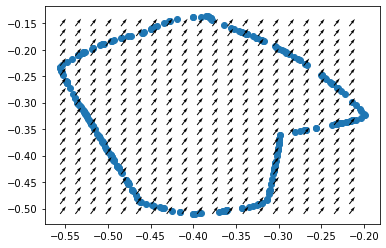

 20%|█▉        | 1993/10000 [00:23<01:15, 106.24it/s]

EPOCH 2000.


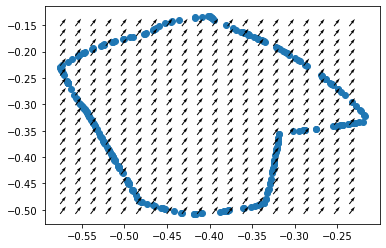

 21%|██        | 2089/10000 [00:24<01:14, 106.79it/s]

EPOCH 2100.


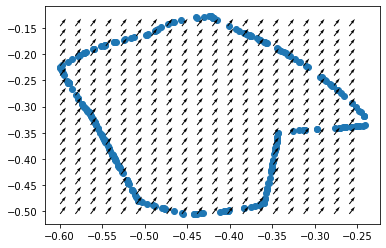

 22%|██▏       | 2196/10000 [00:26<01:17, 101.10it/s]

EPOCH 2200.


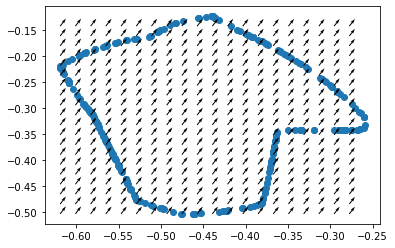

 23%|██▎       | 2292/10000 [00:27<01:12, 105.69it/s]

EPOCH 2300.


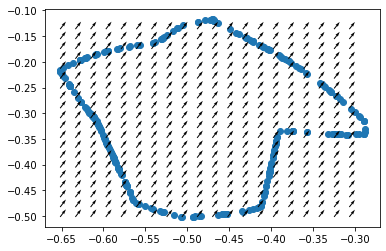

 24%|██▍       | 2400/10000 [00:28<01:10, 108.06it/s]

EPOCH 2400.


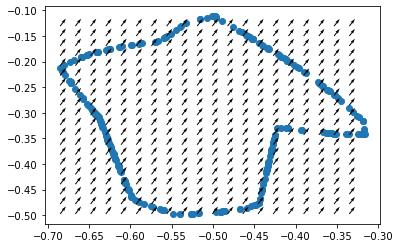

 25%|██▍       | 2496/10000 [00:29<01:11, 105.20it/s]

EPOCH 2500.


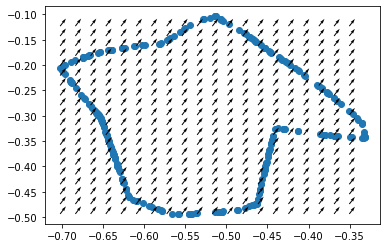

 26%|██▌       | 2592/10000 [00:30<01:10, 105.53it/s]

EPOCH 2600.


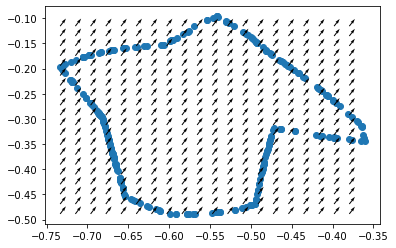

 27%|██▋       | 2700/10000 [00:32<01:07, 108.07it/s]

EPOCH 2700.


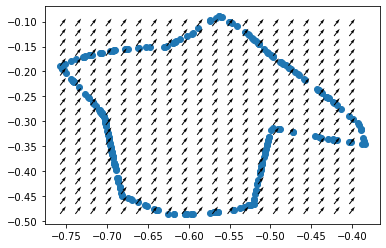

 28%|██▊       | 2796/10000 [00:33<01:08, 105.37it/s]

EPOCH 2800.


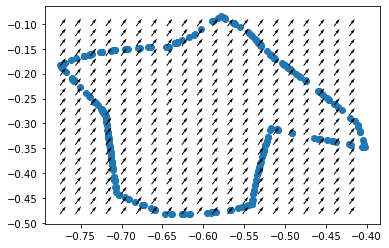

 29%|██▉       | 2892/10000 [00:34<01:07, 105.35it/s]

EPOCH 2900.


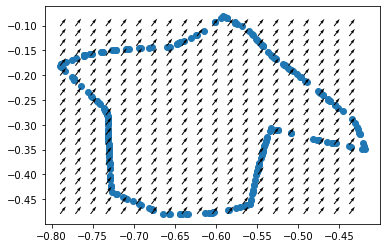

 30%|███       | 3000/10000 [00:35<01:04, 108.73it/s]

EPOCH 3000.


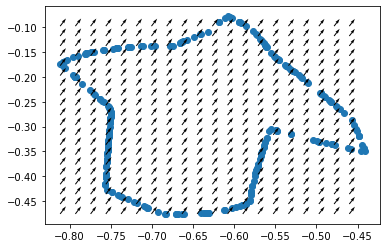

 31%|███       | 3096/10000 [00:36<01:04, 106.30it/s]

EPOCH 3100.


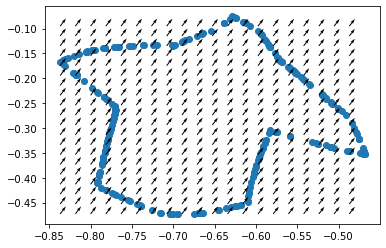

 32%|███▏      | 3192/10000 [00:37<01:04, 105.94it/s]

EPOCH 3200.


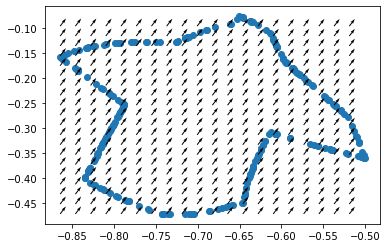

 33%|███▎      | 3299/10000 [00:39<01:06, 100.38it/s]

EPOCH 3300.


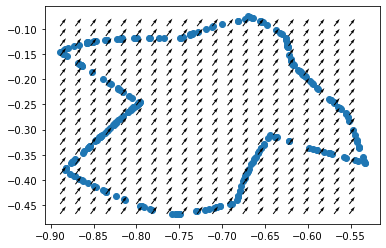

 34%|███▍      | 3394/10000 [00:40<01:02, 105.85it/s]

EPOCH 3400.


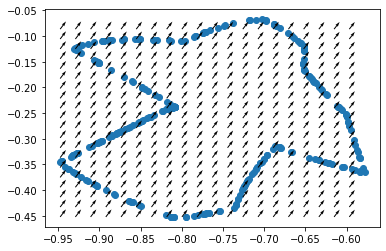

 35%|███▍      | 3490/10000 [00:41<01:01, 105.56it/s]

EPOCH 3500.


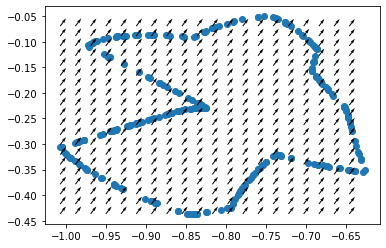

 36%|███▌      | 3598/10000 [00:42<00:59, 108.26it/s]

EPOCH 3600.


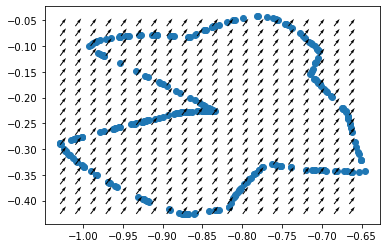

 37%|███▋      | 3694/10000 [00:44<00:58, 107.92it/s]

EPOCH 3700.


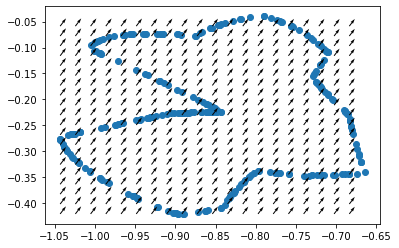

 38%|███▊      | 3790/10000 [00:45<00:58, 105.63it/s]

EPOCH 3800.


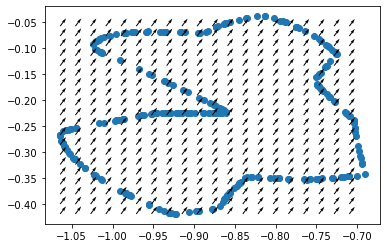

 39%|███▉      | 3898/10000 [00:46<00:56, 108.77it/s]

EPOCH 3900.


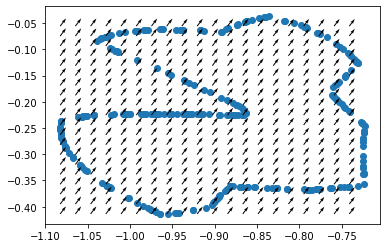

 40%|███▉      | 3994/10000 [00:47<00:56, 106.78it/s]

EPOCH 4000.


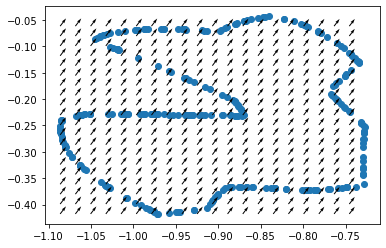

 41%|████      | 4090/10000 [00:48<00:55, 106.22it/s]

EPOCH 4100.


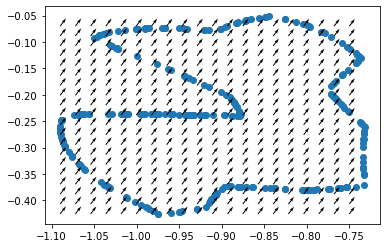

 42%|████▏     | 4198/10000 [00:50<00:53, 107.91it/s]

EPOCH 4200.


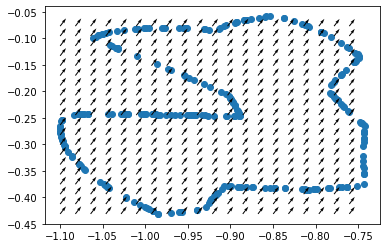

 43%|████▎     | 4294/10000 [00:51<00:54, 105.29it/s]

EPOCH 4300.


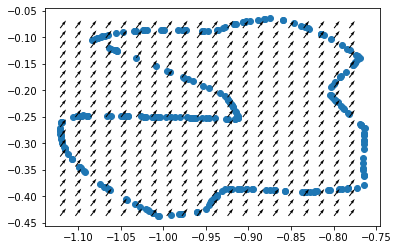

 44%|████▍     | 4390/10000 [00:52<00:53, 105.85it/s]

EPOCH 4400.


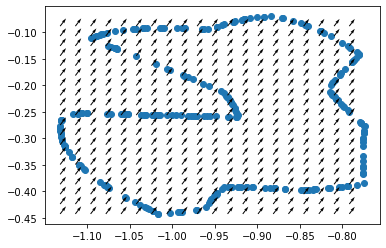

 45%|████▍     | 4497/10000 [00:53<00:54, 100.35it/s]

EPOCH 4500.


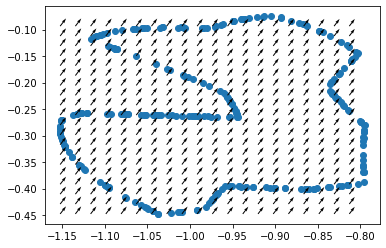

 46%|████▌     | 4593/10000 [00:55<00:51, 105.46it/s]

EPOCH 4600.


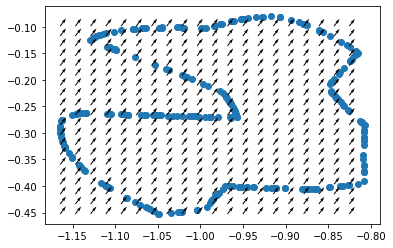

 47%|████▋     | 4689/10000 [00:56<00:50, 105.79it/s]

EPOCH 4700.


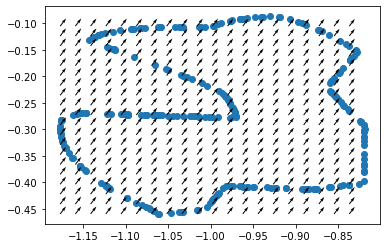

 48%|████▊     | 4797/10000 [00:57<00:47, 108.78it/s]

EPOCH 4800.


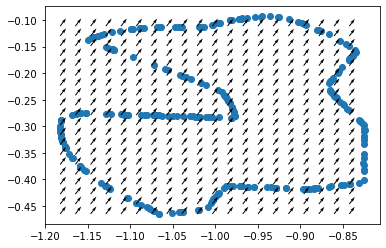

 49%|████▉     | 4893/10000 [00:58<00:47, 107.33it/s]

EPOCH 4900.


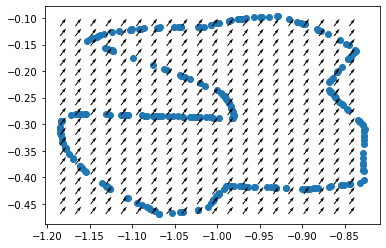

 50%|████▉     | 4989/10000 [00:59<00:46, 107.53it/s]

EPOCH 5000.


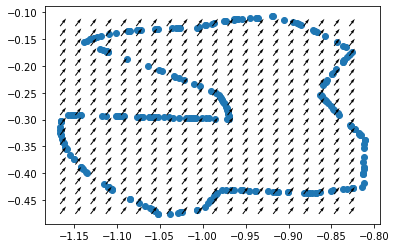

 51%|█████     | 5100/10000 [01:01<01:08, 71.79it/s] 

EPOCH 5100.


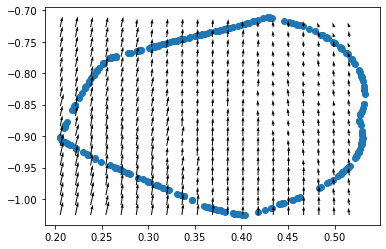

 52%|█████▏    | 5196/10000 [01:03<01:07, 70.76it/s]

EPOCH 5200.


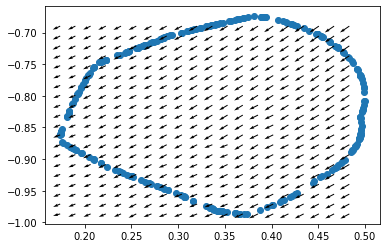

 53%|█████▎    | 5300/10000 [01:04<01:06, 71.03it/s]

EPOCH 5300.


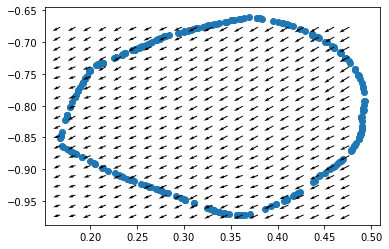

 54%|█████▍    | 5396/10000 [01:06<01:05, 70.77it/s]

EPOCH 5400.


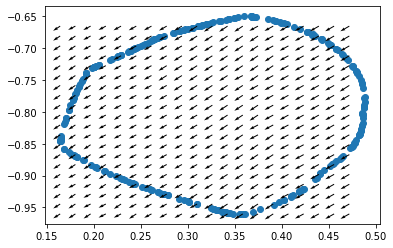

 55%|█████▌    | 5500/10000 [01:08<01:03, 71.41it/s]

EPOCH 5500.


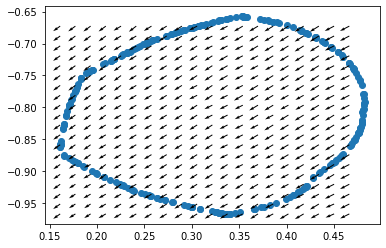

 56%|█████▌    | 5596/10000 [01:09<01:02, 71.02it/s]

EPOCH 5600.


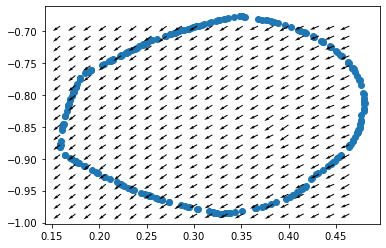

 57%|█████▋    | 5700/10000 [01:11<01:00, 71.43it/s]

EPOCH 5700.


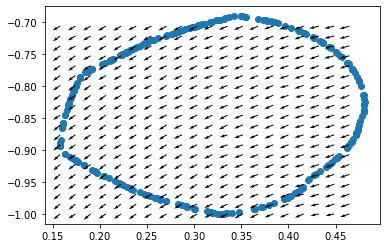

 58%|█████▊    | 5796/10000 [01:13<00:58, 71.54it/s]

EPOCH 5800.


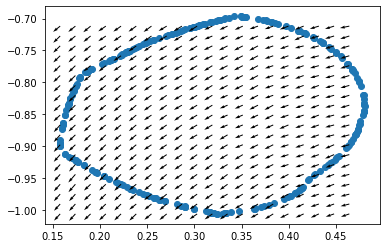

 59%|█████▉    | 5900/10000 [01:15<00:57, 71.58it/s]

EPOCH 5900.


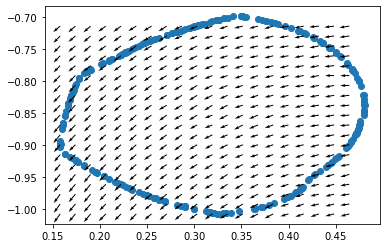

 60%|█████▉    | 5996/10000 [01:16<00:56, 71.28it/s]

EPOCH 6000.


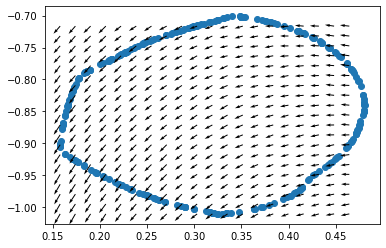

 61%|██████    | 6100/10000 [01:18<00:54, 71.54it/s]

EPOCH 6100.


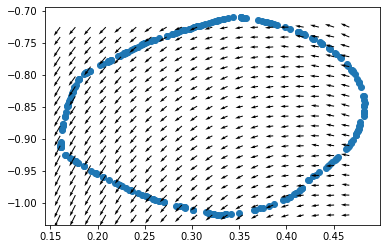

 62%|██████▏   | 6196/10000 [01:20<00:53, 71.23it/s]

EPOCH 6200.


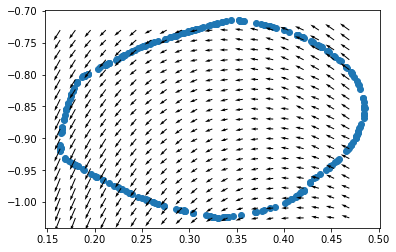

 63%|██████▎   | 6300/10000 [01:21<00:51, 71.39it/s]

EPOCH 6300.


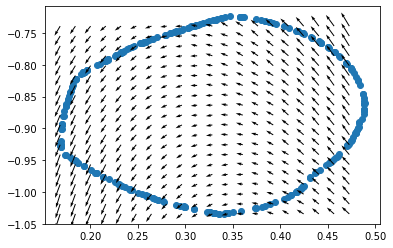

 64%|██████▍   | 6396/10000 [01:23<00:51, 70.49it/s]

EPOCH 6400.


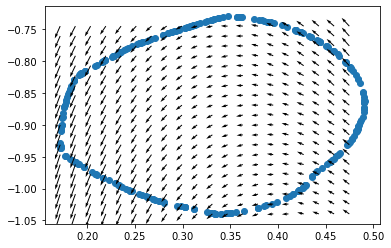

 65%|██████▌   | 6500/10000 [01:25<00:48, 71.87it/s]

EPOCH 6500.


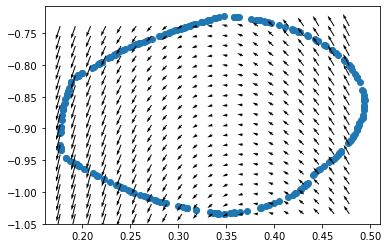

 66%|██████▌   | 6596/10000 [01:27<00:47, 71.18it/s]

EPOCH 6600.


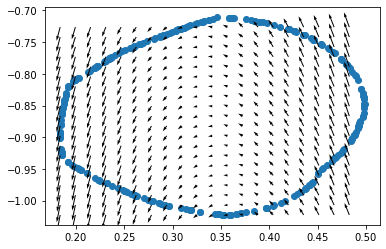

 67%|██████▋   | 6700/10000 [01:28<00:46, 71.61it/s]

EPOCH 6700.


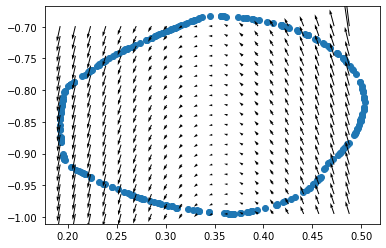

 68%|██████▊   | 6796/10000 [01:30<00:44, 71.29it/s]

EPOCH 6800.


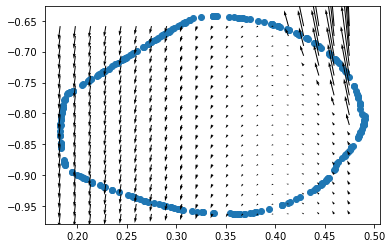

 69%|██████▉   | 6900/10000 [01:32<00:43, 71.49it/s]

EPOCH 6900.


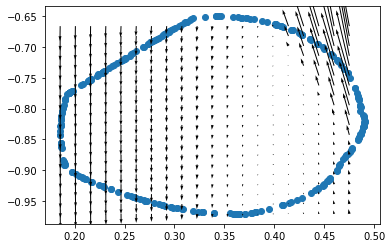

 70%|██████▉   | 6996/10000 [01:33<00:42, 71.16it/s]

EPOCH 7000.


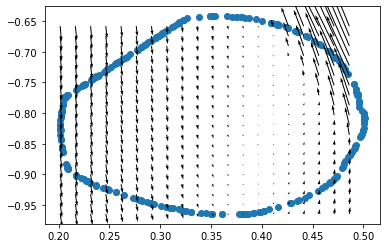

 71%|███████   | 7100/10000 [01:35<00:40, 72.01it/s]

EPOCH 7100.


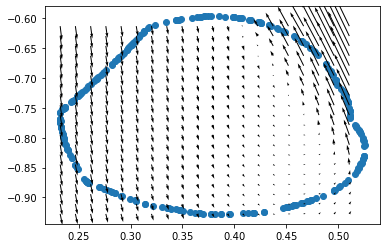

 72%|███████▏  | 7196/10000 [01:37<00:39, 71.24it/s]

EPOCH 7200.


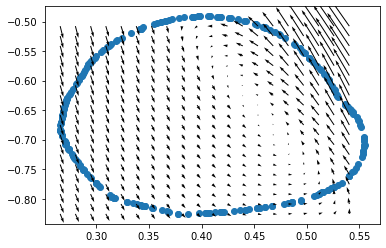

 73%|███████▎  | 7300/10000 [01:38<00:37, 71.61it/s]

EPOCH 7300.


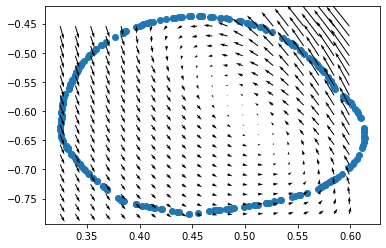

 74%|███████▍  | 7396/10000 [01:40<00:36, 71.30it/s]

EPOCH 7400.


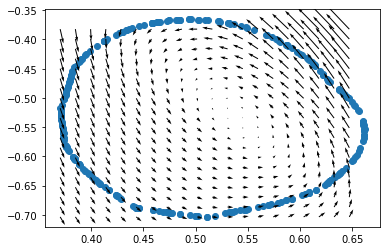

 75%|███████▌  | 7500/10000 [01:42<00:34, 71.44it/s]

EPOCH 7500.


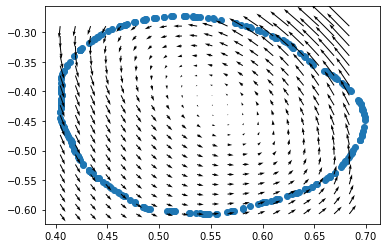

 76%|███████▌  | 7596/10000 [01:43<00:34, 70.48it/s]

EPOCH 7600.


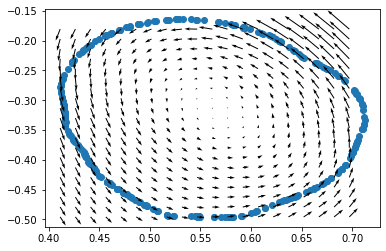

 77%|███████▋  | 7700/10000 [01:45<00:32, 70.88it/s]

EPOCH 7700.


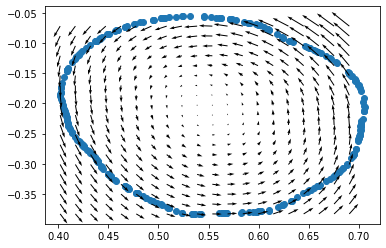

 78%|███████▊  | 7796/10000 [01:47<00:31, 70.77it/s]

EPOCH 7800.


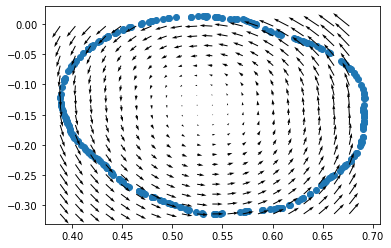

 79%|███████▉  | 7900/10000 [01:49<00:29, 70.75it/s]

EPOCH 7900.


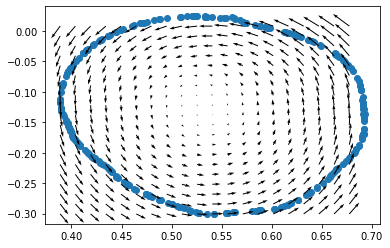

 80%|███████▉  | 7996/10000 [01:50<00:28, 70.58it/s]

EPOCH 8000.


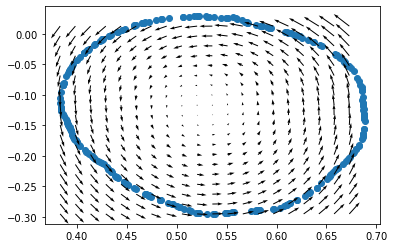

 81%|████████  | 8100/10000 [01:52<00:26, 71.29it/s]

EPOCH 8100.


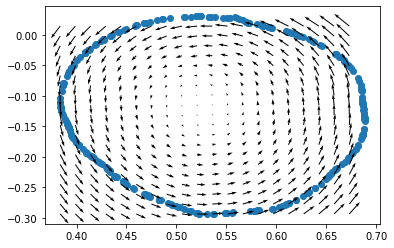

 82%|████████▏ | 8196/10000 [01:54<00:25, 70.99it/s]

EPOCH 8200.


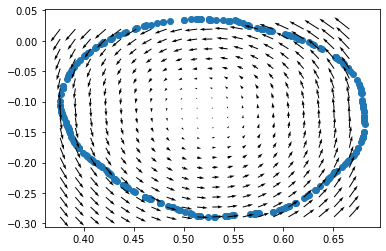

 83%|████████▎ | 8300/10000 [01:55<00:24, 70.75it/s]

EPOCH 8300.


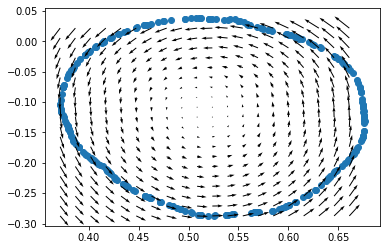

 84%|████████▍ | 8396/10000 [01:57<00:22, 70.79it/s]

EPOCH 8400.


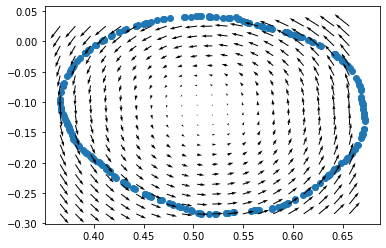

 85%|████████▌ | 8500/10000 [01:59<00:21, 71.31it/s]

EPOCH 8500.


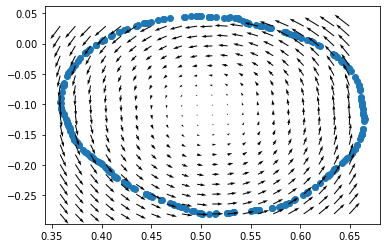

 86%|████████▌ | 8596/10000 [02:00<00:19, 71.08it/s]

EPOCH 8600.


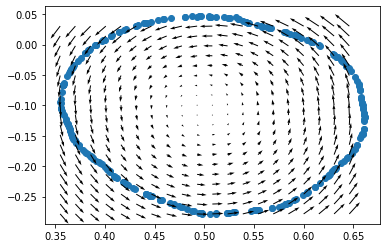

 87%|████████▋ | 8700/10000 [02:02<00:18, 71.31it/s]

EPOCH 8700.


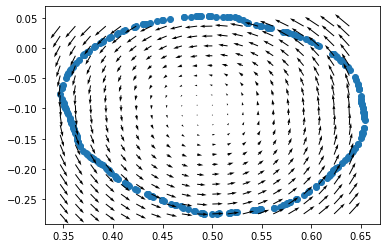

 88%|████████▊ | 8796/10000 [02:04<00:16, 71.59it/s]

EPOCH 8800.


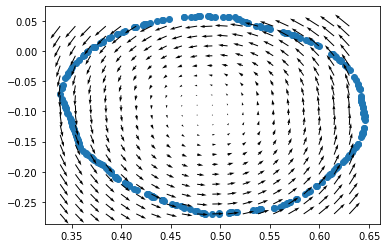

 89%|████████▉ | 8900/10000 [02:06<00:15, 71.86it/s]

EPOCH 8900.


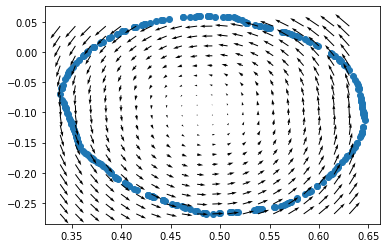

 90%|████████▉ | 8996/10000 [02:07<00:14, 70.33it/s]

EPOCH 9000.


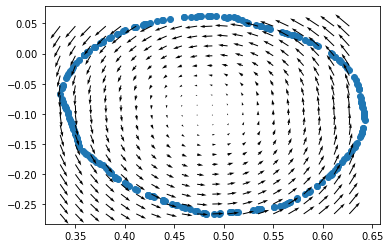

 91%|█████████ | 9100/10000 [02:09<00:12, 71.56it/s]

EPOCH 9100.


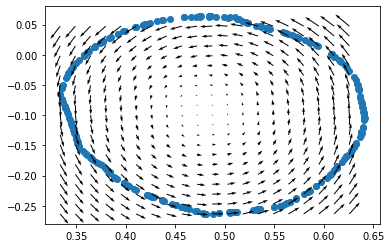

 92%|█████████▏| 9196/10000 [02:11<00:11, 71.30it/s]

EPOCH 9200.


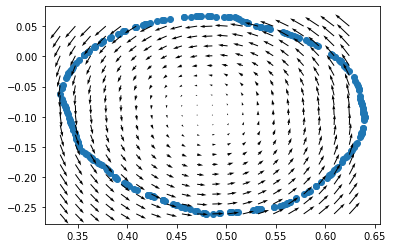

 93%|█████████▎| 9300/10000 [02:13<00:09, 71.46it/s]

EPOCH 9300.


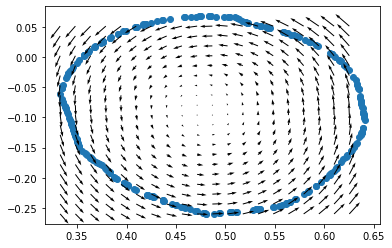

 94%|█████████▍| 9396/10000 [02:14<00:08, 71.21it/s]

EPOCH 9400.


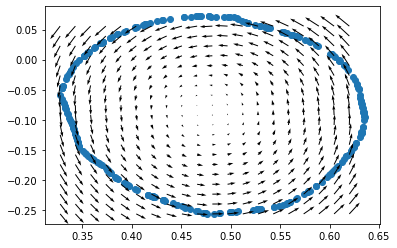

 95%|█████████▌| 9500/10000 [02:16<00:07, 71.24it/s]

EPOCH 9500.


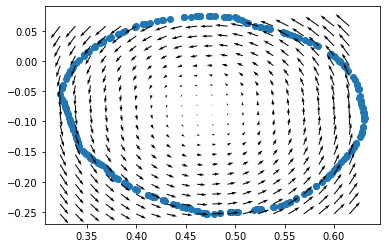

 96%|█████████▌| 9596/10000 [02:18<00:05, 70.88it/s]

EPOCH 9600.


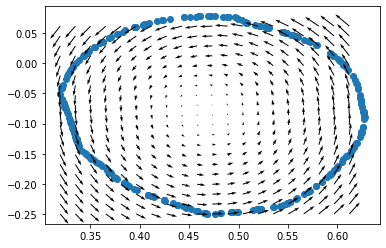

 97%|█████████▋| 9700/10000 [02:19<00:04, 70.53it/s]

EPOCH 9700.


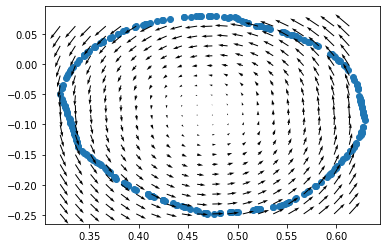

 98%|█████████▊| 9796/10000 [02:21<00:02, 70.72it/s]

EPOCH 9800.


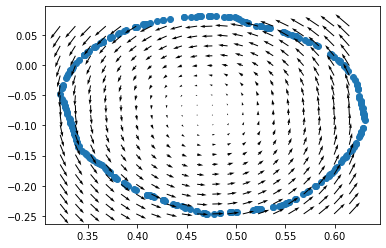

 99%|█████████▉| 9900/10000 [02:23<00:01, 71.37it/s]

EPOCH 9900.


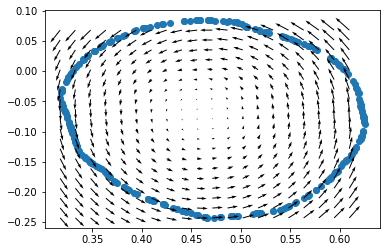

100%|██████████| 10000/10000 [02:24<00:00, 69.04it/s]


In [ ]:
FE.fit(n_steps = 10000)

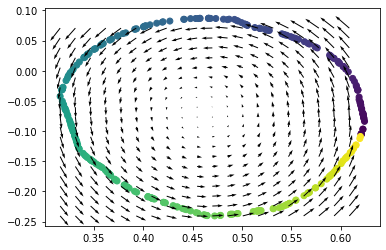

In [ ]:
FE.visualize_points(labels)

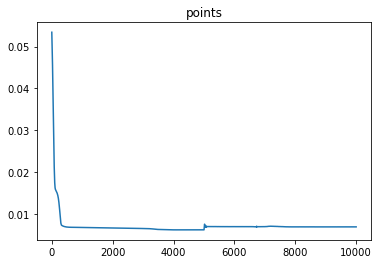

In [ ]:
FE.visualize_loss("points")

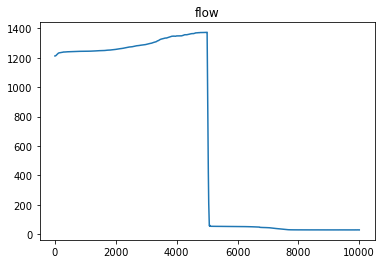

In [ ]:
FE.visualize_loss("flow")

In [ ]:
for w in FE.embedder.parameters():
    print(w)

Parameter containing:
tensor([[-0.1784,  0.5149,  0.5479],
        [ 0.6241,  0.3011,  0.2068],
        [ 0.2269, -0.2139,  0.0444],
        [-0.5219, -0.5131, -0.1879]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.5901,  0.0730, -0.5686,  0.7307], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.4213,  0.3001, -0.2219, -0.6292],
        [ 0.5113, -0.4271, -0.1044, -0.1660],
        [-0.1367, -0.0630, -0.4504,  0.5200],
        [ 0.1051, -0.3699,  0.1254, -0.4836],
        [-0.3743,  0.3947,  0.5644,  0.0667],
        [-0.3466,  0.2910, -0.5562,  0.3547],
        [-0.3284,  0.2069, -0.2524,  0.3638],
        [-0.3164, -0.0336,  0.1740,  0.3811]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 0.0420, -0.3089,  0.3708, -0.3742, -0.2226,  0.0516, -0.4384,  0.4538],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0230,  0.3008, -0.4058,  0.0025,  0.4152, -0.0911, -0.0586, -0.24

In [ ]:
for w in FE.FlowArtist.parameters():
    print(w)

Parameter containing:
tensor([[-0.2421, -0.2210],
        [ 0.1993, -0.1242],
        [-0.5026, -0.3855],
        [-0.0303,  0.6505]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0605,  0.2971,  0.6679,  0.0720], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.2391,  0.3072,  0.3791, -0.2513],
        [-0.0431, -0.4467, -0.3662, -0.4032],
        [ 0.2517, -0.2816,  0.2696, -0.2758],
        [ 0.4639, -0.3285, -0.0298, -0.0325],
        [ 0.4653, -0.3593, -0.1208, -0.1029],
        [ 0.3273, -0.3970, -0.2545,  0.4358],
        [-0.2906, -0.0176, -0.3162,  0.1445],
        [-0.0963, -0.2181,  0.2104, -0.1437]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 0.3894,  0.0833, -0.3068, -0.1772,  0.0448,  0.4881, -0.4401,  0.1208],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0015, -0.3379,  0.0817, -0.2923, -0.2936,  0.2247,  0.0114, -0.2402],
        [-0.2786, -0.0207, -0.2